## Projeto Machine Learning III

Autores:
- Ana Carolina Ferreira
- Diego Dio
- Fernando Brancher
- Marília Melo
- Mayara Medeiros

## Apresentação

**Objetivo:**

Criar modelos de classificação para prever se o tomador do empréstimo ficará inadimplente ou não.

Fonte de dados: https://www.kaggle.com/datasets/laotse/credit-card-approval

*Encontrei esse dicionário no projeto de outra pessoa, não é oficial, mas deve ajudar* (remover antes da apresnetação)

- **ID** = Customer ID of Applicant
- **year** = Year of Application
- **loan limit** = maximum avaliable amount of the loan allowed to be taken
- **Gender** = sex type
- **approv_in_adv** = Is loan pre-approved or not
- **loan_type** = Type of loan
- **loan_purpose** = the reason you want to borrow money
- **Credit_Worthiness** = is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit.
- **open_credit** = is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit.
- **business_or_commercial** = Usage type of the loan amount
- **loan_amount** = The exact loan amount
- **rate_of_interest** = is the amount a lender charges a borrower and is a percentage of the principal—the amount loaned.
- **Interest_rate_spread** = the difference between the interest rate a financial institution pays to depositors and the interest rate it receives from loans
- **Upfront_charges** = Fee paid to a lender by a borrower as consideration for making a new loan
- **term** = the loan's repayment period
- **Neg_ammortization** = refers to a situation when a loan borrower makes a payment less than the standard installment set by the bank.
- **interest_only** = amount of interest only without principles
- **lump_sum_payment** = is an amount of money that is paid in one single payment rather than in installments.
- **property_value** = the present worth of future benefits arising from the ownership of the property
- **construction_type** = Collateral construction type
- **occupancy_type** = classifications refer to categorizing structures based on their usage
- **Secured_by** = Type of Collatoral
- **total_units** = number of unites
- **income** = refers to the amount of money, property, and other transfers of value received over a set period of time
- **credit_type** = type of credit
- **co-applicant_credit_type** = is an additional person involved in the loan application process. Both applicant and co-applicant apply and sign for the loan
- **age** = applicant's age
- **submission_of_application** = Ensure the application is complete or not
- **LTV** = life-time value (LTV) is a prognostication of the net profit
- **Region** = applicant's place
- **Security_Type** = Type of Collatoral
- **status** = Loan status (Approved/Declined)
- **dtir1** = debt-to-income ratio (percentage of income that will be compromised with the loan)

### Etapas projeto (apagar para apresentação final):
- Verificar uso de over/undersampling (não sei como faz nem onde se encaixaria)
- Considerando que temos mais de 500mil amostras, fazer uma subamostragem para análise exploratória, etapas subsequentes de testes de modelo, usando o dataset completo somente para rodar o modelo final com os hiperparâmetros já definidos. 
- Análise Exploratória inicial (atualizar análise após divisão do dataset em treino/teste)
    - describe
    - Mostrar dados em gráficos ao invés de tabelas
    - Distribuições de variáveis categóricas e numéricas
    - heatmap de correlação entre variáveis
- Column Transformer, divisão em X_train, X_test, y_train, y_test
    - Stratify no split de treino/teste devido ao desbalanceamento
    - Scaler (ver qual usar de acordo com as distribuições dos dados)
    - OneHot/Ordinal Encoder
- Seleção de features
- PCA para redução de dimensionalidade
- Modelo não supervisionado para verificar clusters de clientes e padrões no dataset
- Teste de 3 ou 4 modelos com grid/random search (lembrar que essa parte costuma demorar)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
#Rodar uma vez, pra ele mostrar todas as colunas
pd.set_option('display.max_columns', 50)

## 1. Leitura, tratamento e padronização dos dados

In [4]:
df = pd.read_csv('Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [95]:
print(df.shape)
df.info()

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 148670 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              148670 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148670 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

### Características do dataset:
- 148670 linhas
- 34 colunas
    - 1 coluna ID
    - 1 coluna target - Status
    - 21 colunas com dados categóricos
    - 11 colunas com dados numéricos

In [9]:
df.isnull().sum()
# Fazer o tratamento dos nulos no dataset já separado em treino e teste.
# Por exemplo, usar a média de uma coluna pra preencher os dados faltantes no treino,
# e usar a mesma média do treino pra preencher os dados faltantes no teste. (Evita o dataleakage)

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [6]:
X = df.drop(columns='Status')
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(REMOVER DEPOIS)

**Fernando:** Analisei feature por feature aqui, um pouco da distribuição delas, o que significam, dados faltantes... Abaixo tem algumas ações que desempenhei

In [ ]:
# Estudar um pocuo mais das features (não entendi tão bem seu significado): rate_of_interest, Interest_rate_spread, Neg_ammortization, interest_only,

# Analisar necessidade da feature: "Interest_rate_spread" (muitos nulos e parece não ser tão relevante pro modelo) 

In [ ]:
# SUGESTÃO DE ENCODING para depois

# OneHotEnconder: loan_limit, Gender, approv_in_adv, loan_type, loan_purpose, Credit_Worthiness, open_credit, business_or_commercial, Neg_ammortization, interest_only,lump_sum_payment, occupancy_type, credit_type,
#                 co-applicant_credit_type, submission_of_application, Region, Security_Type

# Talvez na feature "term" criar setores: 0-100, 100-200, ....
# OrdinalEncoder: term, total_units, age

# Scaler: loan_amount, rate_of_interest, Upfront_charges, property_value, income, Credit_Score, LTV, dtir1

Tinha pensando em remover essas features abaixo porque achei elas muito desbalanceadas e poderia criar ruído no modelo. Acontece que os 33 valores que aparecem são para os mesmos clientes (df abaixo) e todos ficaram com status 1, ai acho que da pra deixar no modelo pois é um padrão que algoritmo deve reconhecer durante a modelagem.

Deixei isso aqui só pra todo mundo dar uma olhada e ter conhecimento, depois podemos remover.

In [ ]:
# Caso específico
print(df["construction_type"].value_counts())
print("\n")
print(df["Secured_by"].value_counts())
print("\n")
print(df["Security_Type"].value_counts())

construction_type
sb    148637
mh        33
Name: count, dtype: int64


Secured_by
home    148637
land        33
Name: count, dtype: int64


Security_Type
direct      148637
Indriect        33
Name: count, dtype: int64


In [119]:
df[df["construction_type"] == "mh"][["construction_type", "Secured_by", "Security_Type", "Status"]].head()

,construction_type,Secured_by,Security_Type,Status
7973,mh,land,Indriect,1
32312,mh,land,Indriect,1
34412,mh,land,Indriect,1
35368,mh,land,Indriect,1
36155,mh,land,Indriect,1


### Análise do target

In [52]:
df['Status'].value_counts(normalize=True)

Status
0    0.753555
1    0.246445
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribuição da aprovação de empréstimo'}, xlabel='Aprovação', ylabel='Porcentagem'>

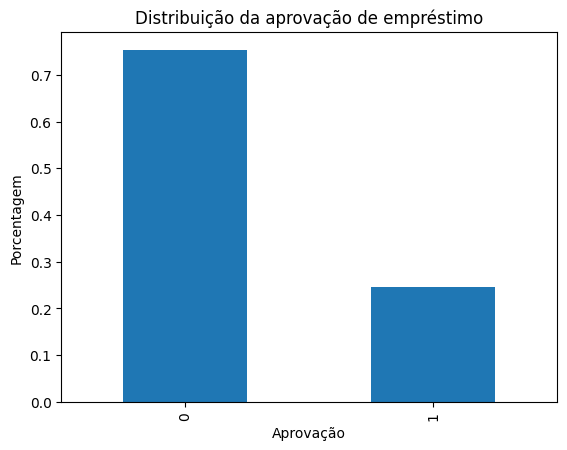

In [51]:
# Análise de balanceamento do target do dataset
sns.
# df['Status'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da aprovação de empréstimo',
#                                                ylabel='Porcentagem',
#                                                xlabel='Aprovação')

Nosso target ```Status``` é desbalanceado, podemos pensar em maneira de equilibrar a distribuição. 

Ideias:

- *Undersampling:* remover parte das observações da classe 0 para balancear. Sugestão, algo em torno de 60-40% acho que já seria OK.
- *Oversamplig:* criar dados sintéticos para a classe 1, até um o momento de criar uma distribuição mais balanceada.

Como temos um bom valor na classe 1, acredito que o *undersampling* já nos ajude, para evitar a criação de dados sintéticos.

### Análise dos dados faltantes

Colunas com dados faltantes: ```['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'property_value', 'income', 'age', 'submission_of_application', 'LTV', 'dtir1']```

In [53]:
# Checar valores nulos
df.isnull().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [75]:
df_nulos = df.copy()

#### Dados Categóricos

Abaixo preenchi os valores faltantes com ```NULO```, para então analisar a distribuição dos demais dados na feature, usando hue: 'Status'.

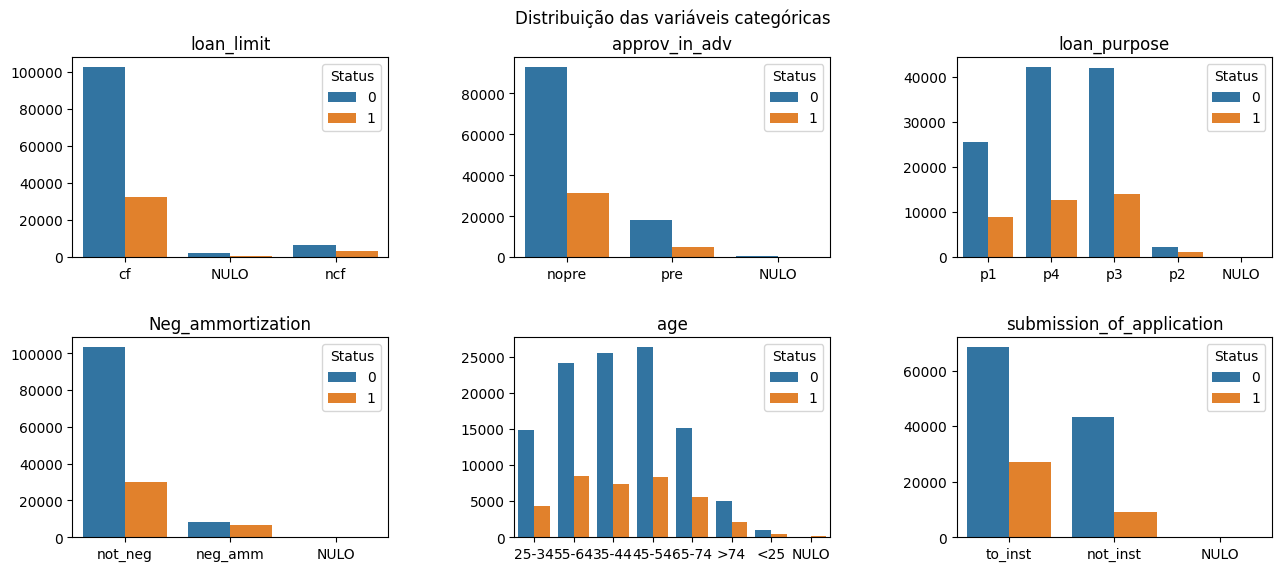

In [64]:
category_list = ['loan_limit', 'approv_in_adv', 'loan_purpose',  'Neg_ammortization',  'age', 'submission_of_application']
count = 1

plt.subplots(2,3, figsize=(15,6))

for category in category_list:
    plt.subplot(2,3,count)
    sns.countplot(data = df_nulos[['loan_limit', 'approv_in_adv', 'loan_purpose',  'Neg_ammortization',  'age', 'submission_of_application', 'Status']].fillna('NULO'),
                  x=category, 
                  hue='Status')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(category)
    count += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
plt.suptitle('Distribuição das variáveis categóricas')
plt.show()

Nos dados categóricos os nulos são pouco representativos, praticamente não aparecem.

Assim, estes dados foram preenchidos com a **moda**.

**GRUPO: revejam esta decissão e se acharem pertinente podem alterar.** Principalmente age, talvez deveria ser revisto

In [72]:
# ['loan_limit', 'approv_in_adv', 'loan_purpose',  'Neg_ammortization',  'age', 'submission_of_application']
df['loan_limit'].fillna('cf', inplace=True)
df['approv_in_adv'].fillna('nopre', inplace=True)
df['loan_purpose'].fillna('p3', inplace=True)
df['Neg_ammortization'].fillna('not_neg', inplace=True)
df['age'].fillna('45-54', inplace=True) # talvez preencher com o kNN imputer (menciono ele depois melhor)
df['submission_of_application'].fillna('to_inst', inplace=True)

#### Dados numéricos

In [92]:
# Valores nulo quando Status = 0 ou = 1
df_status0 = df[df['Status'] == 0].copy()
df_status1 = df[df['Status'] == 1].copy()

indices = df_status1.isna().sum().index
valores_status0 = np.array(df_status0.isna().sum())
valores_status1 = np.array(df_status1.isna().sum())
df_valores_nulos = pd.DataFrame({'coluna': indices, 'Status 0': valores_status0, 'Status 1': valores_status1})
df_valores_nulos

,coluna,Status 0,Status 1
0,ID,0,0
1,year,0,0
2,loan_limit,0,0
3,Gender,0,0
4,approv_in_adv,0,0
5,loan_type,0,0
6,loan_purpose,0,0
7,Credit_Worthiness,0,0
8,open_credit,0,0
9,business_or_commercial,0,0


Analisando o dataframe acima, observamos que:
- Em ```rate_of_interest``` e ```Interest_rate_spread``` todos os dados nulos estão nos dados com **Status 1**
- Em ```Upfront_charges```, ```property_value``` e  ```LTV``` a grande maioria dos nulos estão nos dados com **Status 1**
- Em ```term```, ```income``` e ```dtir1``` os dados nulos estão bem distribuídos

**Plano de Ação:**

Preencher os dados faltantes com que estratégia?
- Média de cada feature?
- Igual a zero ?
- kNN imputation: estratégia que li [nessa matéria](https://www.blog.dailydoseofds.com/p/the-most-overlooked-problem-with-768?utm_source=post-email-title&publication_id=1119889&post_id=135561523&isFreemail=true&utm_medium=email) de uma newsletter que sigo

<Axes: xlabel='term', ylabel='Count'>

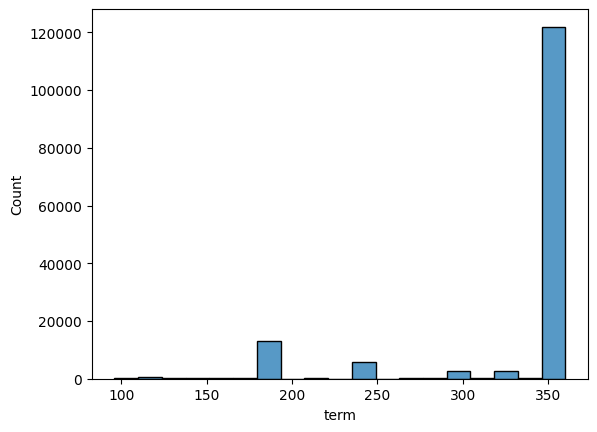

In [152]:
# "term" está como numérica, mas acredito que poderiamos fazer uma categorização
# 0 - 120 (0-10 anos)
# 121 - 240 (10-20 anos)
# 240+ (20+ anos)
sns.histplot(data=df, x='term')

### Remoção de colunas 

In [116]:
# Remover coluna ID, pois é um identificador
df.drop(columns='ID', inplace=True)

## 2. Visualização das distribuições

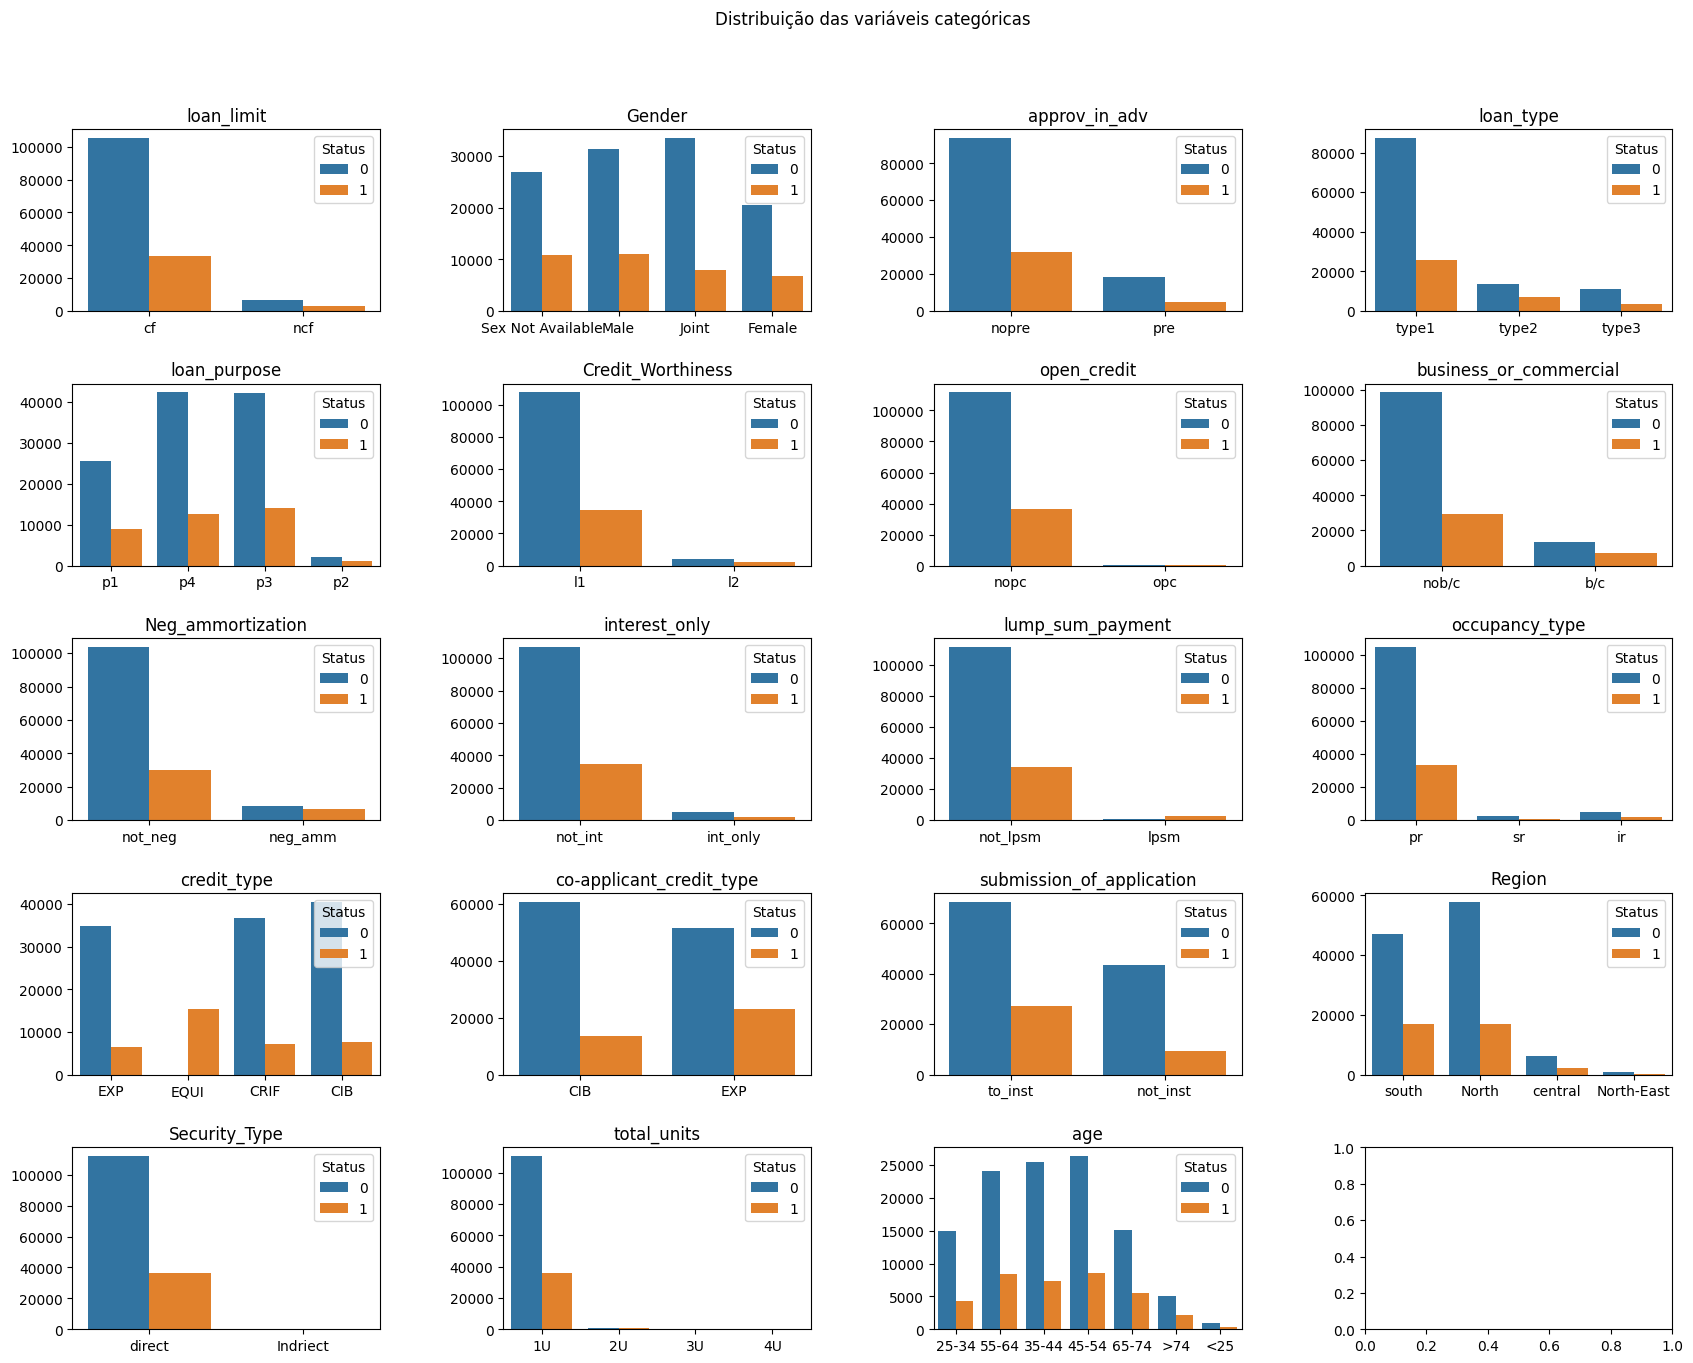

In [128]:
# Distribuição das variáveis categóricas
category_list = ["loan_limit", "Gender", "approv_in_adv", "loan_type", "loan_purpose", "Credit_Worthiness", "open_credit", "business_or_commercial", "Neg_ammortization", "interest_only", \
                 "lump_sum_payment", "occupancy_type", "credit_type", "co-applicant_credit_type", "submission_of_application", "Region", "Security_Type", "total_units", "age"]
count = 1

plt.subplots(5, 4, figsize=(20,15))

for category in category_list:
    plt.subplot(5,4, count)
    sns.countplot(data = df,
                  x=category, 
                  hue='Status')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(category)
    count += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
plt.suptitle('Distribuição das variáveis categóricas')
plt.show()

In [150]:
pd.crosstab(df['total_units'],df['Status'])


Status,0,1
total_units,,
1U,110597,35883
2U,967,510
3U,242,151
4U,225,95
